<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/Alexnet%20final/Alexnet%20TL%20pytorch%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Download dataset dari Kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
corn-or-maize-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/data/Blight/Corn_Blight (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/Blight/Corn_Blight (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/Blight/Corn_Blight (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
['Healthy', 'Gray_Leaf_Spot', 'Blight', 'Common_Rust']


In [10]:
# Image size
IMAGE_SIZE = 227

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Function to make data
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img_list.append(path)
        label_list.append(label)

# Dataset directory
dataset_dir = '/content/data'

# Lists to hold image paths and labels
image_paths = []
labels = []

# Load data
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(i, class_dir, image_paths, labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

100%|██████████| 1146/1146 [00:00<00:00, 437965.59it/s]


In [11]:
# Split data into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Datasets and dataloaders
train_dataset = CustomDataset(train_paths, train_labels, transform=data_transforms['train'])
val_dataset = CustomDataset(test_paths, test_labels, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [13]:
# Model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(le.classes_))

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)

# Training function
def train_model(model, criterion, optimizer, num_epochs=50):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6783 Acc: 0.7555
val Loss: 0.3950 Acc: 0.8556

Epoch 1/9
----------
train Loss: 0.3833 Acc: 0.8654
val Loss: 0.3269 Acc: 0.8783

Epoch 2/9
----------
train Loss: 0.3282 Acc: 0.8758
val Loss: 0.2938 Acc: 0.8831

Epoch 3/9
----------
train Loss: 0.2900 Acc: 0.8937
val Loss: 0.2759 Acc: 0.8950

Epoch 4/9
----------
train Loss: 0.2747 Acc: 0.8967
val Loss: 0.2685 Acc: 0.8986

Epoch 5/9
----------
train Loss: 0.2630 Acc: 0.8949
val Loss: 0.2514 Acc: 0.9010

Epoch 6/9
----------
train Loss: 0.2505 Acc: 0.9024
val Loss: 0.2498 Acc: 0.8962

Epoch 7/9
----------
train Loss: 0.2394 Acc: 0.9125
val Loss: 0.2395 Acc: 0.9093

Epoch 8/9
----------
train Loss: 0.2239 Acc: 0.9152
val Loss: 0.2298 Acc: 0.9105

Epoch 9/9
----------
train Loss: 0.2357 Acc: 0.9090
val Loss: 0.2262 Acc: 0.9129

Best val Acc: 0.912888


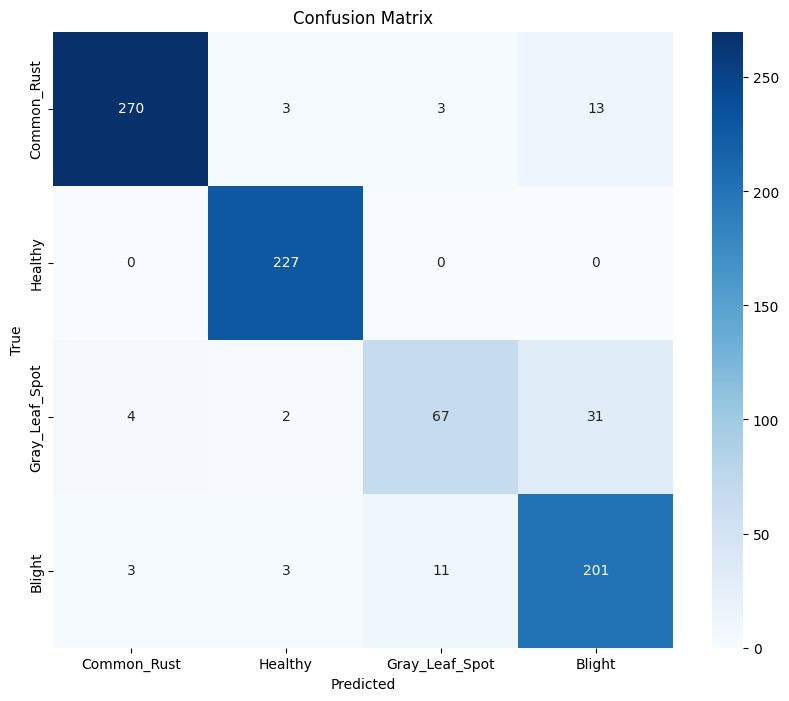


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       289
           1       0.97      1.00      0.98       227
           2       0.83      0.64      0.72       104
           3       0.82      0.92      0.87       218

    accuracy                           0.91       838
   macro avg       0.90      0.88      0.88       838
weighted avg       0.91      0.91      0.91       838



In [19]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix and classification report
class_names = [str(cls) for cls in le.classes_]
class_report = classification_report(all_labels, all_preds, target_names=class_names)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(class_report)